## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 40000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.5,
 5: 25.9,
 10: 26.6,
 20: 27.7,
 30: 28.6,
 40: 29.7,
 50: 31.2,
 60: 33.1,
 70: 35.1,
 80: 37.6,
 90: 41.3,
 95: 44.3,
 99: 50.5}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

print('loaded!')

loaded!


In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    return ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2.5, 3),       # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 44.3 log FLOP (~200 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~116 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.0 years until 2025, and then doubles every 1.6 years to a max of 4.4e-05% of GDP. GDP grows at a rate of 1.036x per year.
There are 5 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> lognorm(mean=2.25, sd=0.7) years if it happens
## Chance of nonscaling delay ##


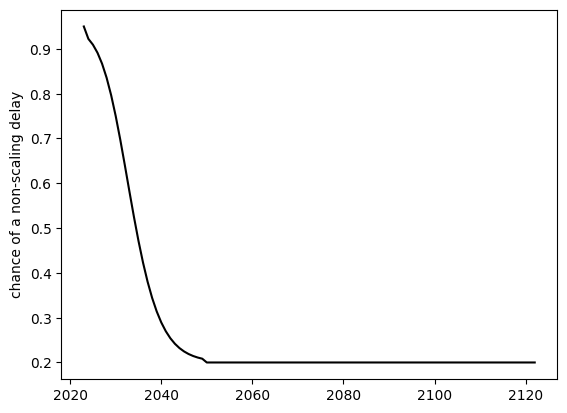

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2033

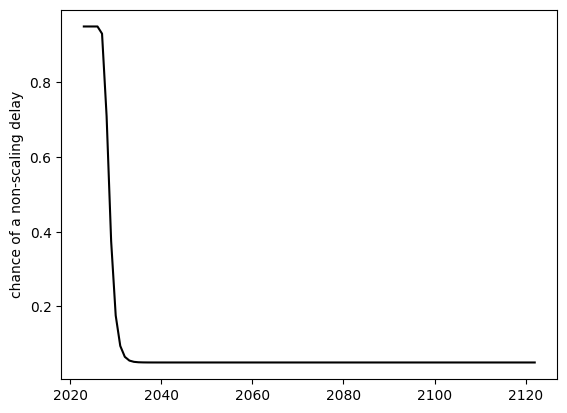

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 93%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 -

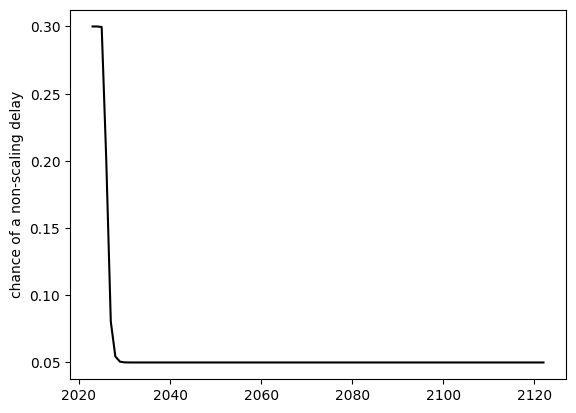

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

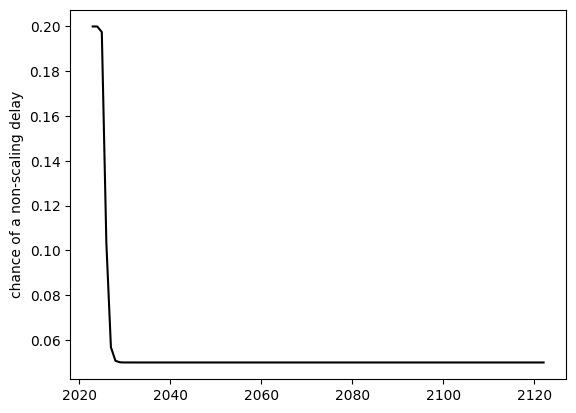

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

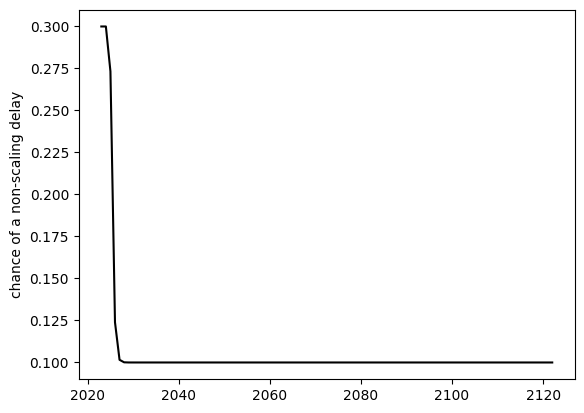

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

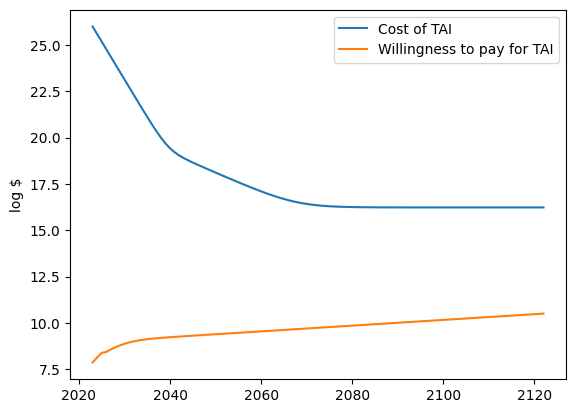

-
-
## SAMPLE RUN 2 ##
It takes 37.7 log FLOP (~50 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 1.0 years until 2025, and then doubles every 3.4 years to a max of 8.9e-05% of GDP. GDP grows at a rate of 1.026x per year.
There are 5 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> lognorm(mean=2.25, sd=0.7) years if it happens
## Chance of nonscaling delay ##


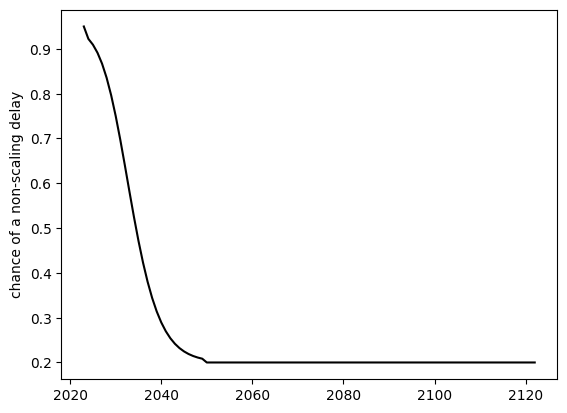

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2033

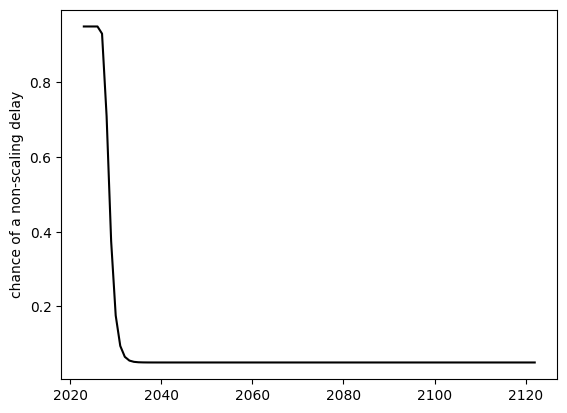

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 93%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 -

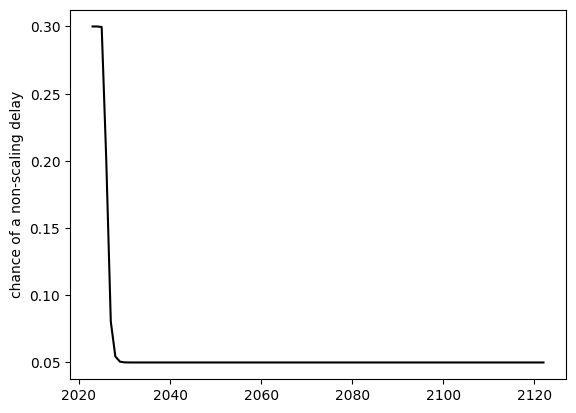

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

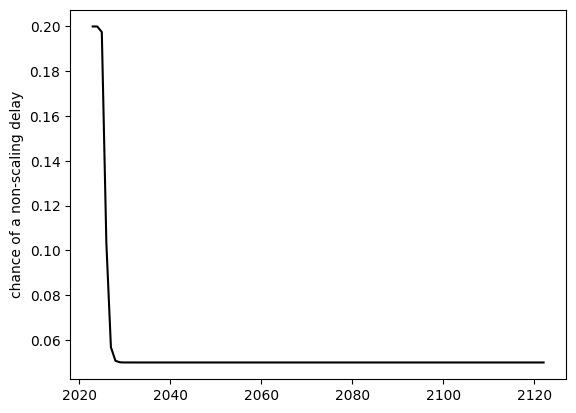

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

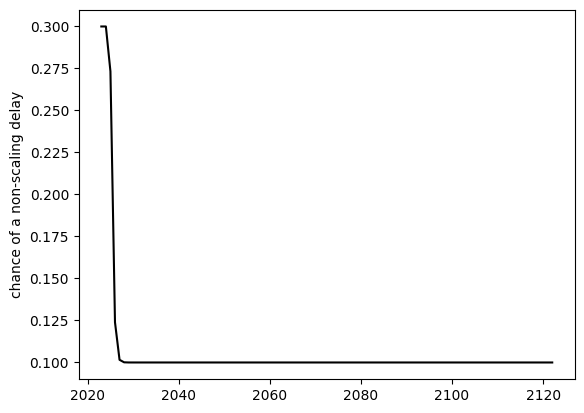

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

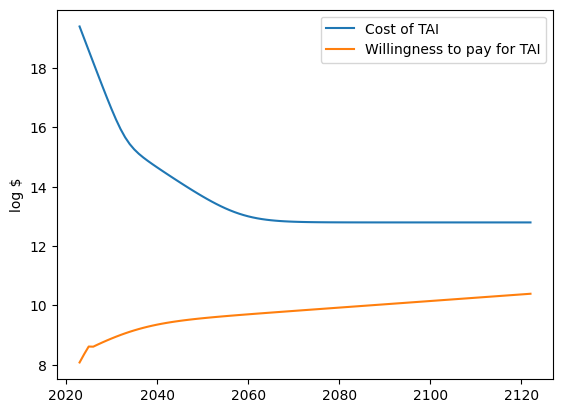

-
-
## SAMPLE RUN 3 ##
It takes 29.6 log FLOP (~398 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~3 billion). This doubles every 1.0 years until 2025, and then doubles every 3.4 years to a max of 0.000394% of GDP. GDP grows at a rate of 1.017x per year.
There are 5 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> lognorm(mean=2.25, sd=0.7) years if it happens
## Chance of nonscaling delay ##


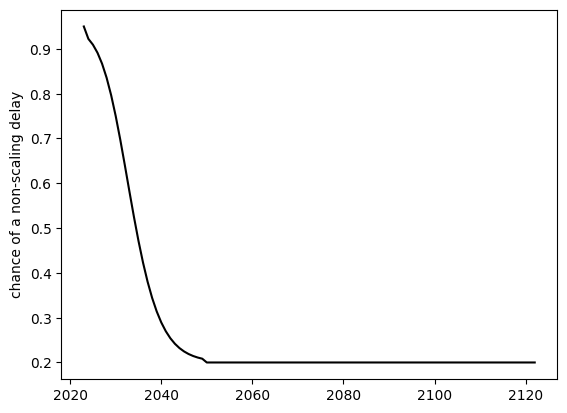

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2033

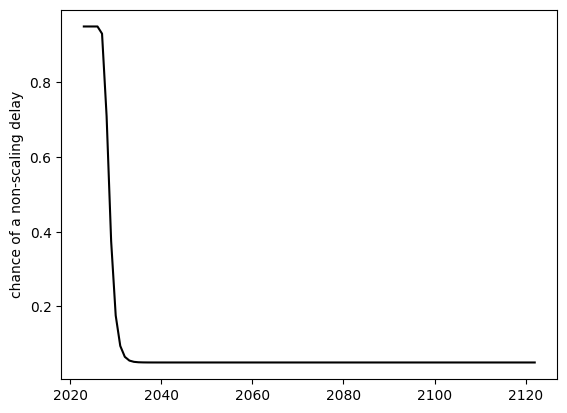

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 93%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 -

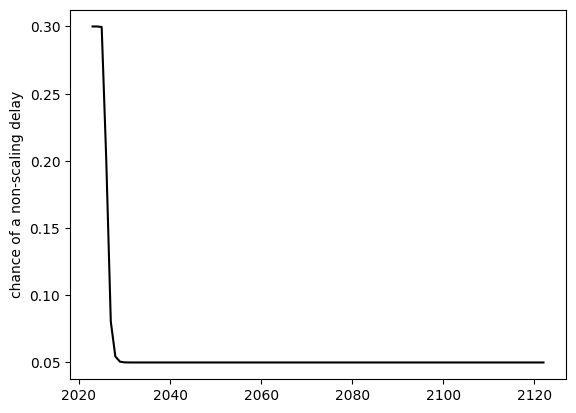

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

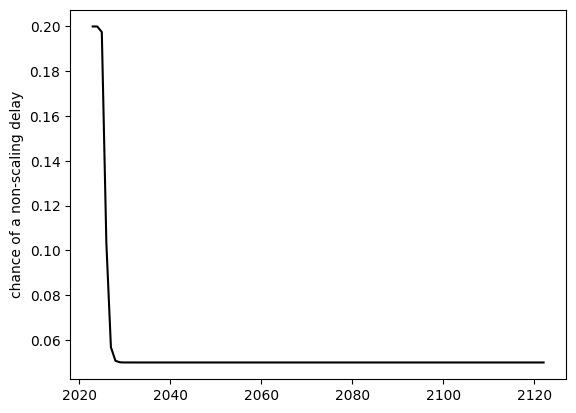

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - cha

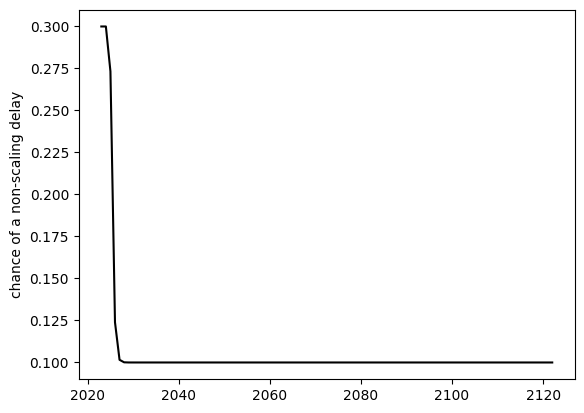

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

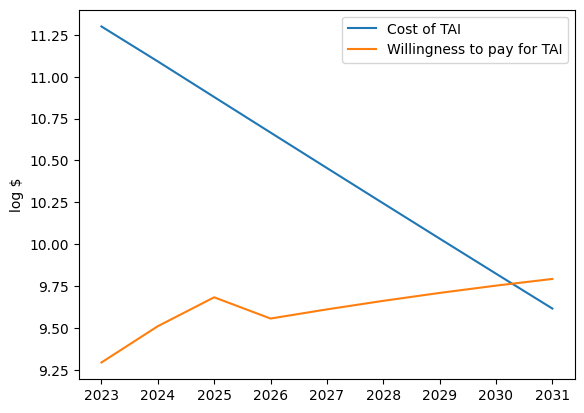

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [04:27<00:00, 149.55it/s]


Shuffling data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1845.60it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2032',
 '10%: 2034',
 '15%: 2036',
 '20%: 2037',
 '25%: 2039',
 '35%: 2042',
 '50%: 2049',
 '60%: 2056',
 '75%: >2123',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 9 years from now',
 '10%: 11 years from now',
 '15%: 13 years from now',
 '20%: 14 years from now',
 '25%: 16 years from now',
 '35%: 19 years from now',
 '50%: 26 years from now',
 '60%: 33 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.1%
2028-2029: 1.6%
2030-2034: 9.8%
2035-2039: 14.8%
2040-2049: 24.4%
2050-2059: 13.0%
2060-2069: 5.4%
2070-2079: 2.6%
2080-2089: 1.2%
2090-2099: 0.8%
2100-2109: 0.5%
2110-2119: 0.5%
>2120: 25.2%
-


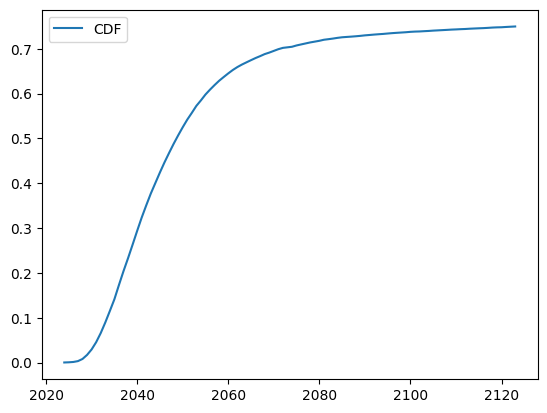

<string>:173: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:174: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

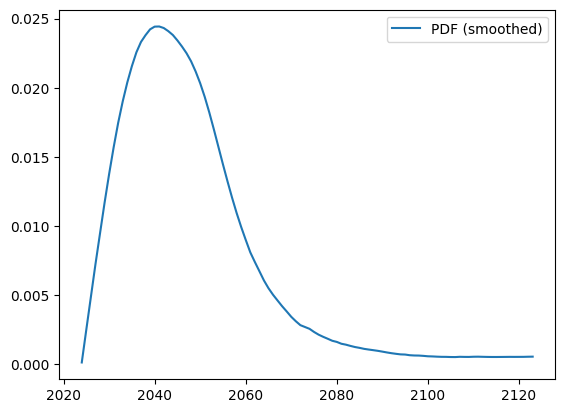

-
-
## TAI FLOP SIZE ##
{1: 24.7,
 5: 26.1,
 10: 26.7,
 20: 27.8,
 30: 28.5,
 40: 29.7,
 50: 31.7,
 60: 33.5,
 70: 35.6,
 80: 37.9,
 90: 41.3,
 95: 43.7,
 99: 49.1}


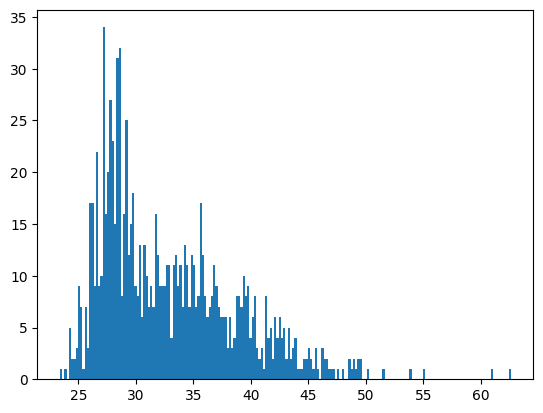

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.1,
 5: 3.0,
 10: 3.0,
 20: 2.9,
 30: 2.8,
 40: 2.8,
 50: 2.8,
 60: 2.7,
 70: 2.7,
 80: 2.6,
 90: 2.5,
 95: 2.5,
 99: 2.4}


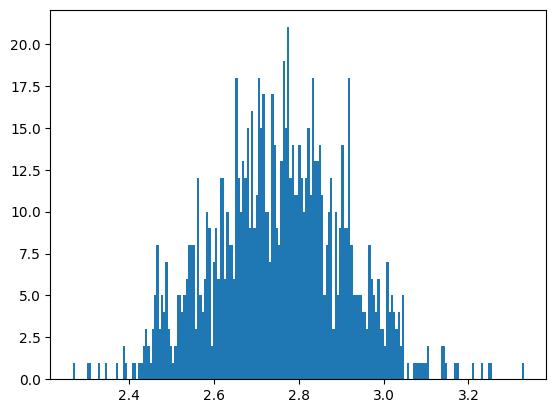

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.4,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.3,
 50: 22.5,
 60: 22.7,
 70: 23.0,
 80: 23.3,
 90: 23.7,
 95: 24.1,
 99: 24.5}


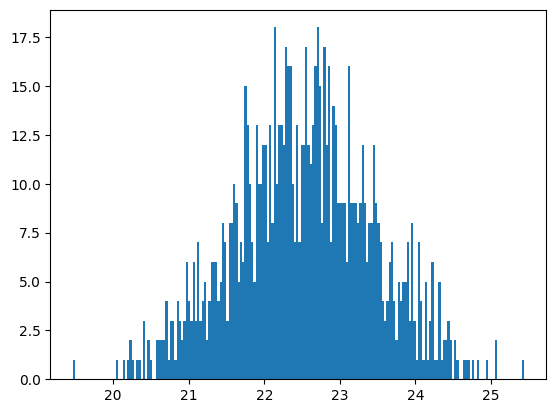

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.8,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.4,
 80: 8.6,
 90: 8.9,
 95: 9.2,
 99: 9.8}


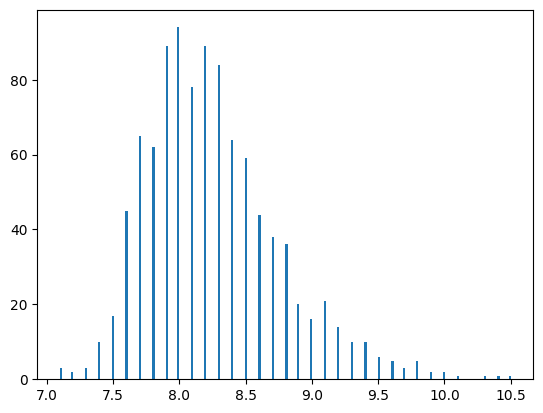

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


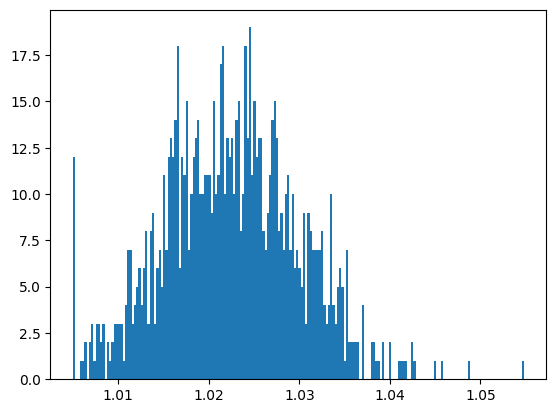

-
-
## MAX GDP FRAC ##
{1: 0.0,
 5: 1e-05,
 10: 5e-05,
 20: 0.00017,
 30: 0.00023,
 40: 0.0003,
 50: 0.00039,
 60: 0.0005,
 70: 0.00066,
 80: 0.00099,
 90: 0.00191,
 95: 0.00362,
 99: 0.00804}


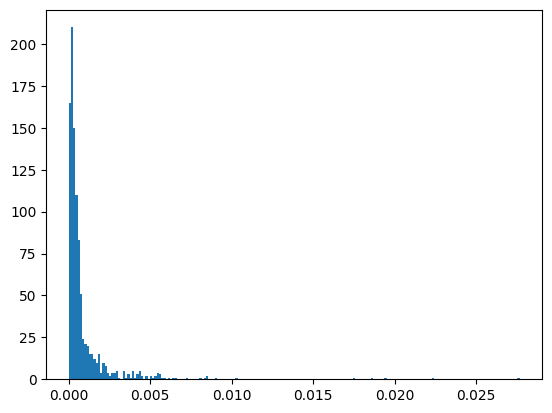

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.1,
 20: 3.8,
 30: 3.5,
 40: 3.3,
 50: 3.1,
 60: 2.8,
 70: 2.6,
 80: 2.2,
 90: 1.9,
 95: 1.6,
 99: 1.0}


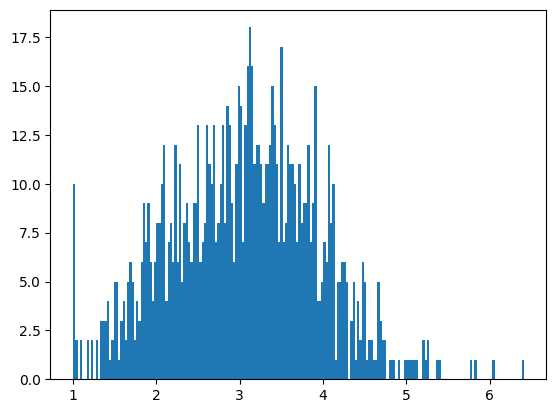

-
-
-
-
## GDP Over Time ##


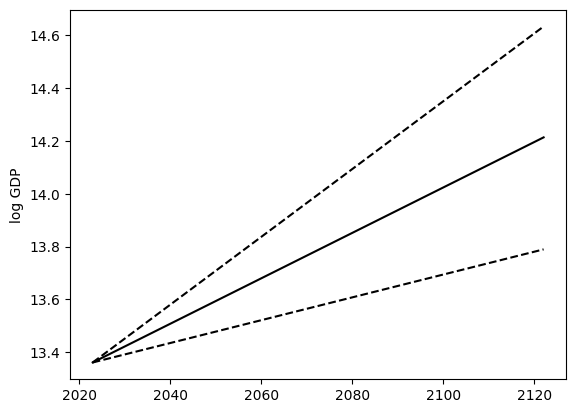

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

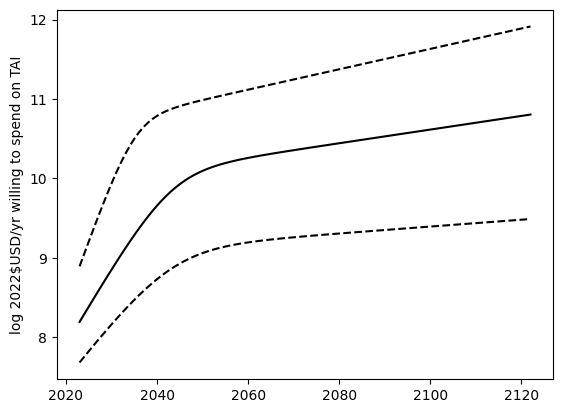

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~48 million) - 8.9 (~780 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~194 million) 90% CI 7.8 (~56 million) - 9.0 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~241 million) 90% CI 7.8 (~66 million) - 9.2 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~300 million) 90% CI 7.9 (~78 million) - 9.4 (~2 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~373 million) 90% CI 8.0 (~91 million) - 9.5 (~3 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~462 million) 90% CI 8.0 (~106 million) - 9.7 (~4 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~572 million) 90% CI 8.1 (~124 million) - 9.8 (~6 billion)
Year: 2030 - willingness log 2022$USD per year 8.8 (~706 million) 90% CI 8.2 (~144 million) - 9.9 (~9 billion)
Year: 2031 - willingness log 2022$USD per year 8.9 (~870 million) 90% CI 8.2 (~168 million) - 10.1 (~12 billion)
Ye

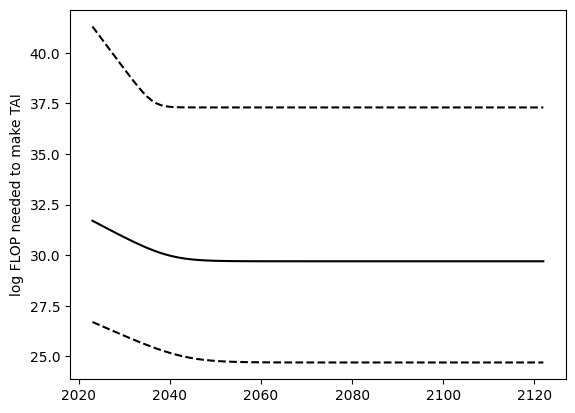

Year: 2023 - log FLOP needed for TAI 31.7 (~50 nonillion) 90% CI 26.7 (~501 septillion) - 41.3 (~200 million decillion)
Year: 2024 - log FLOP needed for TAI 31.6 (~38 nonillion) 90% CI 26.6 (~403 septillion) - 41.0 (~100 million decillion)
Year: 2025 - log FLOP needed for TAI 31.5 (~29 nonillion) 90% CI 26.5 (~321 septillion) - 40.7 (~50 million decillion)
Year: 2026 - log FLOP needed for TAI 31.3 (~22 nonillion) 90% CI 26.4 (~256 septillion) - 40.4 (~25 million decillion)
Year: 2027 - log FLOP needed for TAI 31.2 (~17 nonillion) 90% CI 26.3 (~204 septillion) - 40.1 (~12 million decillion)
Year: 2028 - log FLOP needed for TAI 31.1 (~13 nonillion) 90% CI 26.2 (~163 septillion) - 39.8 (~6 million decillion)
Year: 2029 - log FLOP needed for TAI 31.0 (~10 nonillion) 90% CI 26.1 (~130 septillion) - 39.5 (~3 million decillion)
Year: 2030 - log FLOP needed for TAI 30.9 (~8 nonillion) 90% CI 26.0 (~104 septillion) - 39.2 (~2 million decillion)
Year: 2031 - log FLOP needed for TAI 30.8 (~6 noni

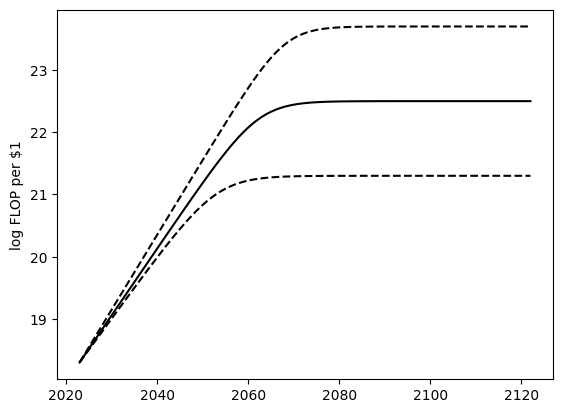

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.5 (~3 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.7 (~5 quintillion) - 18.8 (~6 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.8 (~7 quintillion) 90% CI 18.8 (~6 quintillion) - 18.9 (~8 quintillion)
Year: 2029 - log FLOP per 2022$1USD 18.9 (~9 quintillion) 90% CI 18.9 (~8 quintillion) - 19.0 (~11 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~11 quintillion) 90% CI 19.0 (~10 quintillion) - 19.1 (~14 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.2 (~14 quintillion) 90% CI 19.1 (~13 quintillion) - 19.3 (~18 quintil

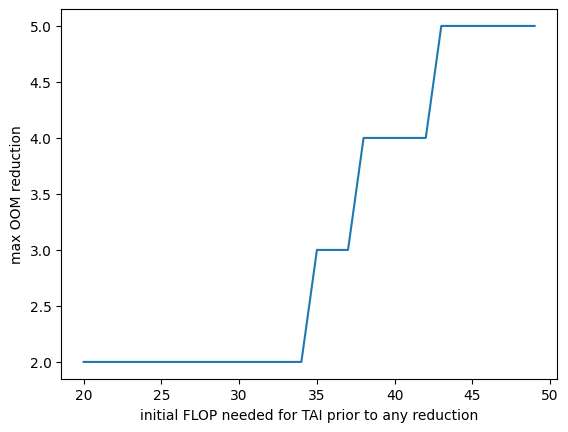

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

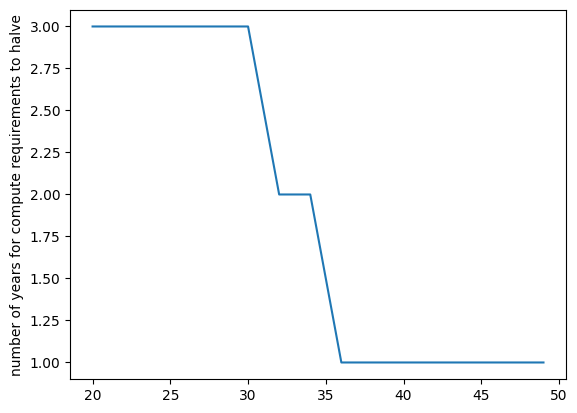

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

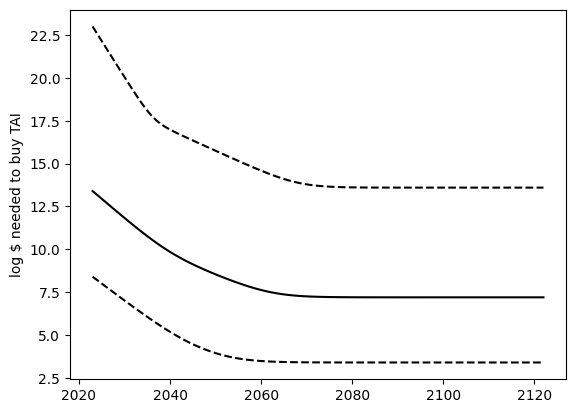

Year: 2023 - 13.4 log 2022$USD to buy TAI (~25 trillion) 90% CI 8.4 (~251 million) - 23.0 (~100 sextillion)
Year: 2024 - 13.2 log 2022$USD to buy TAI (~15 trillion) 90% CI 8.2 (~160 million) - 22.6 (~38 sextillion)
Year: 2025 - 13.0 log 2022$USD to buy TAI (~9 trillion) 90% CI 8.0 (~101 million) - 22.2 (~14 sextillion)
Year: 2026 - 12.7 log 2022$USD to buy TAI (~5 trillion) 90% CI 7.8 (~64 million) - 21.7 (~5 sextillion)
Year: 2027 - 12.5 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.6 (~41 million) - 21.3 (~2 sextillion)
Year: 2028 - 12.3 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.4 (~26 million) - 20.9 (~784 quintillion)
Year: 2029 - 12.1 log 2022$USD to buy TAI (~1 trillion) 90% CI 7.2 (~16 million) - 20.5 (~298 quintillion)
Year: 2030 - 11.8 log 2022$USD to buy TAI (~682 billion) 90% CI 7.0 (~10 million) - 20.1 (~114 quintillion)
Year: 2031 - 11.6 log 2022$USD to buy TAI (~412 billion) 90% CI 6.8 (~7 million) - 19.6 (~44 quintillion)
Year: 2032 - 11.4 log 2022$USD to buy TAI (

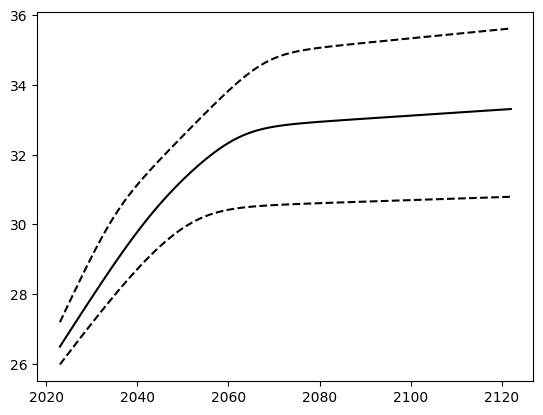

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~96 septillion) - 27.2 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~496 septillion) 90% CI 26.2 (~142 septillion) - 27.5 (~3 octillion)
Year: 2025 - max log FLOP 26.9 (~790 septillion) 90% CI 26.3 (~210 septillion) - 27.7 (~6 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~310 septillion) - 28.0 (~10 octillion)
Year: 2027 - max log FLOP 27.3 (~2 octillion) 90% CI 26.7 (~457 septillion) - 28.3 (~19 octillion)
Year: 2028 - max log FLOP 27.5 (~3 octillion) 90% CI 26.8 (~672 septillion) - 28.6 (~36 octillion)
Year: 2029 - max log FLOP 27.7 (~5 octillion) 90% CI 27.0 (~987 septillion) - 28.8 (~66 octillion)
Year: 2030 - max log FLOP 27.9 (~8 octillion) 90% CI 27.2 (~1 octillion) - 29.1 (~119 octillion)
Year: 2031 - max log FLOP 28.1 (~13 octillion) 90% CI 27.3 (~2 octillion) - 29.3 (~213 octillion)
Year: 2032 - max log FLOP 28.3 (~20 octillion) 90% CI 27.5 (~3 octillion) - 29.6 (~374 octillion)
Year: 203

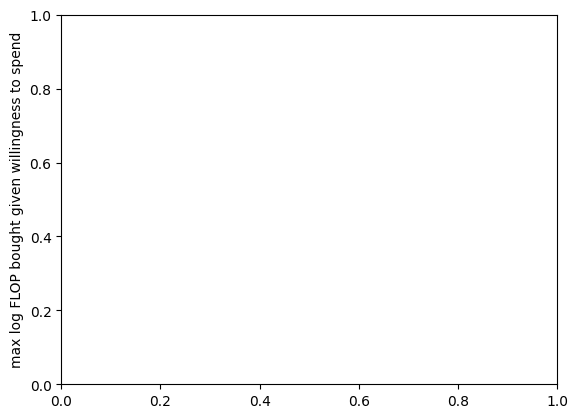

In [7]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR
run_timelines_model(variables, cores=5, runs=variables['RUNS'], dump_cache_file='caches/tai_years')